## Engrgy Consumption forecasting with LSTM

- In this project I have trained RNN model to predict the energy consumption by home appliences

- The Dataset used in this project is available on UCI Machine learning libraby with following link 
https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction

- Dataset Description:

1. Appliances, energy consumption by Home appliances in Wh
2. lights, energy use of light fixtures in the house in Wh
3. T1, Temperature in kitchen area, in Celsius
4. RH_1, Humidity in kitchen area, in %
5. T2, Temperature in living room area, in Celsius
6. RH_2, Humidity in living room area, in %
7. T3, Temperature in laundry room area
8. RH_3, Humidity in laundry room area, in %
9. T4, Temperature in office room, in Celsius
10. RH_4, Humidity in office room, in %
11. T5, Temperature in bathroom, in Celsius
12. RH_5, Humidity in bathroom, in %
13. T6, Temperature outside the building (north side), in Celsius
14. RH_6, Humidity outside the building (north side), in %
15. T7, Temperature in ironing room , in Celsius
16. RH_7, Humidity in ironing room, in %
17. T8, Temperature in teenager room 2, in Celsius
18. RH_8, Humidity in teenager room 2, in %
19. T9, Temperature in parents room, in Celsius
20. RH_9, Humidity in parents room, in %
21. To, Temperature outside (from Chievres weather station), in Celsius
22. Pressure (from Chievres weather station), in mm Hg
23. RH_out, Humidity outside (from Chievres weather station), in %
24. Wind speed (from Chievres weather station), in m/s
25. Visibility (from Chievres weather station), in km
26. Tdewpoint (from Chievres weather station), Â°C
27. rv1, Random variable 1, nondimensional
28. rv2, Random variable 2, nondimensional

## 1. Importing Libraries

In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Importing Dataset

In [86]:
df = pd.read_csv('/content/energydata_complete.csv')

In [87]:
df

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,45.566667,17.166667,55.200000,7.026667,84.256667,17.200000,41.626667,18.2000,48.900000,17.033333,45.5300,6.600000,733.5,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,45.992500,17.166667,55.200000,6.833333,84.063333,17.200000,41.560000,18.2000,48.863333,17.066667,45.5600,6.483333,733.6,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,45.890000,17.166667,55.090000,6.560000,83.156667,17.200000,41.433333,18.2000,48.730000,17.000000,45.5000,6.366667,733.7,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,45.723333,17.166667,55.090000,6.433333,83.423333,17.133333,41.290000,18.1000,48.590000,17.000000,45.4000,6.250000,733.8,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,45.530000,17.200000,55.090000,6.366667,84.893333,17.200000,41.230000,18.1000,48.590000,17.000000,45.4000,6.133333,733.9,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,45.590000,23.200000,52.400000,24.796667,1.000000,24.500000,44.500000,24.7000,50.074000,23.200000,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,45.590000,23.230000,52.326667,24.196667,1.000000,24.557143,44.414286,24.7000,49.790000,23.200000,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,45.730000,23.230000,52.266667,23.626667,1.000000,24.540000,44.400000,24.7000,49.660000,23.200000,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,45.790000,23.200000,52.200000,22.433333,1.000000,24.500000,44.295714,24.6625,49.518750,23.200000,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784


## 3.Exploratory Data Analysis

In [88]:
df['date'] = pd.to_datetime(df['date'] )

**3.1 Checking Correlation between independent and dependent variables**

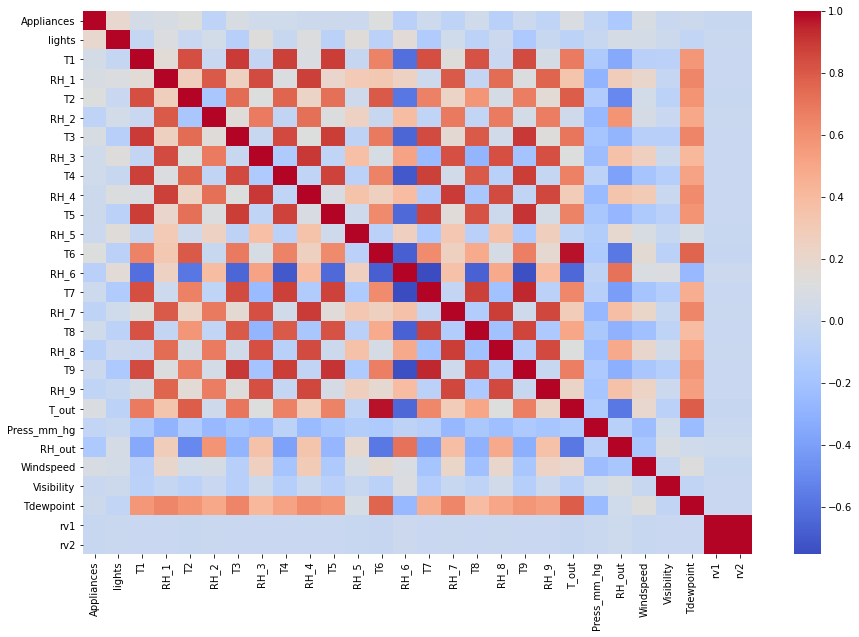

In [89]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),cmap='coolwarm')
plt.show()

**Observation**
1. Temperature and Humidity values are highly correlated with each other respectively

2. Appliance value has neutral relation with other variables



**3.2 Checking Energy consumption with respect to time**

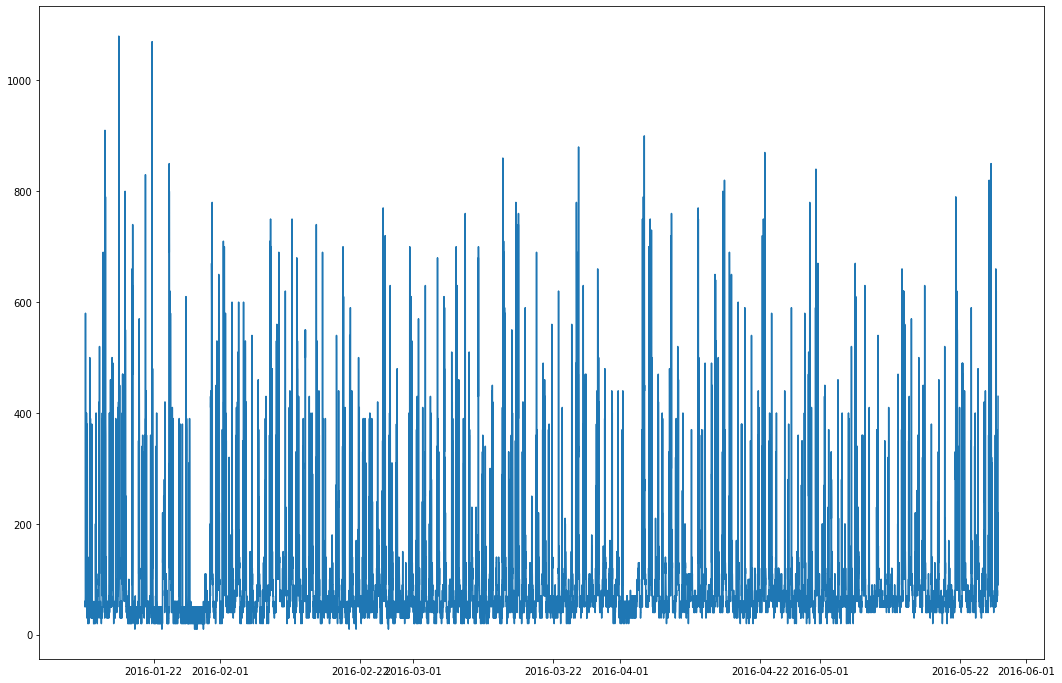

In [90]:
plt.figure(figsize=(18,12))
plt.plot(df.date,df.Appliances)
plt.show()

**Observation**

- There is seasonality in energy consumption with respect to time.
 
- Energy consumption shows periodic rise in value  

## 4.Data Preprocessing

**4.1 Defining dataframe with selective variables which don't have high correlation with each other**

In [91]:
df1 = df[['Appliances','T1', 'RH_1','Press_mm_hg', 'RH_out', 'Windspeed']]
df1.head()

,Appliances,T1,RH_1,Press_mm_hg,RH_out,Windspeed
0,60,19.89,47.596667,733.5,92.0,7.000000
1,60,19.89,46.693333,733.6,92.0,6.666667
2,50,19.89,46.300000,733.7,92.0,6.333333
3,50,19.89,46.066667,733.8,92.0,6.000000
4,60,19.89,46.333333,733.9,92.0,5.666667


**4.2 Scalling Datapoints with MinMaxScaler**

In [92]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

In [93]:
df1 = sc.fit_transform(df1)
df1

array([[0.04672897, 0.32734952, 0.56618659, 0.09767442, 0.89473684,
        0.5       ],
       [0.04672897, 0.32734952, 0.54132648, 0.1       , 0.89473684,
        0.47619048],
       [0.03738318, 0.32734952, 0.53050179, 0.10232558, 0.89473684,
        0.45238095],
       ...,
       [0.24299065, 0.91974657, 0.53866618, 0.60232558, 0.4254386 ,
        0.26190476],
       [0.38317757, 0.91974657, 0.54949087, 0.60232558, 0.42982456,
        0.27380952],
       [0.39252336, 0.91974657, 0.53875791, 0.60232558, 0.43421053,
        0.28571429]])

**4.2 Defining Independent and Target Variable**

In [94]:
X = df1
y = df1[:,0]

**4.3 Dividing the dataset into Training and Testing Dataset**

In [95]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle = False)

In [96]:
X_train.shape

(13814, 6)

In [97]:
X_test.shape

(5921, 6)

 ## 5.Creating a data structure 

**5.1 Importing TimeseriesGenerator**

In [20]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator 

**5.2 Using 280 Time steps with single sampling rate to prepare data structure**

In [21]:
Time_stamps = 280
features = 6

In [22]:
Train_set = TimeseriesGenerator(X_train, y_train,
                               length=Time_stamps, sampling_rate=1,
                               batch_size=32)

In [24]:
Test_set = TimeseriesGenerator(X_test, y_test,
                               length=Time_stamps, sampling_rate=1,
                               batch_size=32)

 ## 6.Building and Training the RNN

**6.1 Importing the Keras libraries and packages**

In [99]:
from tensorflow.keras.layers import Dense,Activation,LSTM,Dropout
from tensorflow.keras.models import Sequential
model = Sequential()


**6.2 Adding the LSTM layers and some Dropout regularisation**

In [27]:
## first layer of lstm
model.add(LSTM(130,input_shape = (Time_stamps, features),return_sequences= True))
model.add(Dropout(0.2))

## Second layer of lstm
model.add(LSTM(130,return_sequences= True))
model.add(Dropout(0.2))

## Third layer of lstm
model.add(LSTM(130,return_sequences= True))
model.add(Dropout(0.2))

## forth layer of lstm
model.add(LSTM(130))
model.add(Dropout(0.2))

model.add(Dense(1))



In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 280, 130)          71240     
_________________________________________________________________
dropout (Dropout)            (None, 280, 130)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 280, 130)          135720    
_________________________________________________________________
dropout_1 (Dropout)          (None, 280, 130)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 280, 130)          135720    
_________________________________________________________________
dropout_2 (Dropout)          (None, 280, 130)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 130)               1

**6.3 Compiling the RNN**

In [29]:
model.compile( optimizer='rmsprop', loss = 'mean_squared_error')

## 7.Model Fitting and Prediction 

**7.1 Fitting model on Train_Set and validating with Test_set**

In [31]:
model.fit_generator(Train_set,epochs=15,validation_data= Test_set, shuffle= False)

Epoch 1/15
423/423 [==============================] - 33s 77ms/step - loss: 0.0071 - val_loss: 0.0041
Epoch 2/15
423/423 [==============================] - 31s 74ms/step - loss: 0.0049 - val_loss: 0.0038
Epoch 3/15
423/423 [==============================] - 31s 74ms/step - loss: 0.0046 - val_loss: 0.0034
Epoch 4/15
423/423 [==============================] - 31s 74ms/step - loss: 0.0045 - val_loss: 0.0032
Epoch 5/15
423/423 [==============================] - 31s 74ms/step - loss: 0.0044 - val_loss: 0.0031
Epoch 6/15
423/423 [==============================] - 31s 74ms/step - loss: 0.0044 - val_loss: 0.0032
Epoch 7/15
423/423 [==============================] - 31s 74ms/step - loss: 0.0044 - val_loss: 0.0033
Epoch 8/15
423/423 [==============================] - 31s 74ms/step - loss: 0.0043 - val_loss: 0.0031
Epoch 9/15
423/423 [==============================] - 31s 74ms/step - loss: 0.0043 - val_loss: 0.0031
Epoch 10/15
423/423 [==============================] - 31s 74ms/step - loss: 0.004

**7.2 Predicting Values for Test_set**

In [32]:
predictions = model.predict_generator(Test_set)

Instructions for updating:
Please use Model.predict, which supports generators.


In [33]:
predictions.shape

(5641, 1)

In [35]:
y_test.shape

(5921,)

In [37]:
pred_df = pd.DataFrame(predictions)
pred_df.head()

,0
0,0.062587
1,0.039691
2,0.061688
3,0.033935
4,0.034547


In [70]:
y_test_df = pd.DataFrame(y_test[280:])
y_test_df.head()


,0
0,0.028037
1,0.046729
2,0.018692
3,0.018692
4,0.028037


In [58]:
test_df = pd.DataFrame(X_test[:,1:][Time_stamps:])
test_df.head()

,0,1,2,3,4
0,0.535023,0.238785,0.762791,0.394737,0.285714
1,0.527983,0.235758,0.763178,0.392544,0.285714
2,0.527983,0.234107,0.763566,0.390351,0.285714
3,0.527983,0.232364,0.763953,0.388158,0.285714
4,0.527983,0.230529,0.764341,0.385965,0.285714


In [59]:
test_df.shape

(5641, 5)

In [73]:
merged_df = pd.concat([pred_df,test_df],axis=1)
merged_df.head()

,0,0,1,2,3,4
0,0.062587,0.535023,0.238785,0.762791,0.394737,0.285714
1,0.039691,0.527983,0.235758,0.763178,0.392544,0.285714
2,0.061688,0.527983,0.234107,0.763566,0.390351,0.285714
3,0.033935,0.527983,0.232364,0.763953,0.388158,0.285714
4,0.034547,0.527983,0.230529,0.764341,0.385965,0.285714


In [72]:
merged_df2 = pd.concat([y_test_df,test_df],axis=1)
merged_df2.head()

,0,0,1,2,3,4
0,0.028037,0.535023,0.238785,0.762791,0.394737,0.285714
1,0.046729,0.527983,0.235758,0.763178,0.392544,0.285714
2,0.018692,0.527983,0.234107,0.763566,0.390351,0.285714
3,0.018692,0.527983,0.232364,0.763953,0.388158,0.285714
4,0.028037,0.527983,0.230529,0.764341,0.385965,0.285714


In [74]:
merged_df = sc.inverse_transform(merged_df)
merged_df

array([[ 76.96775563,  21.85666667,  35.7       , 762.1       ,
         54.        ,   4.        ],
       [ 52.46897664,  21.79      ,  35.59      , 762.11666667,
         53.83333333,   4.        ],
       [ 76.00568403,  21.79      ,  35.53      , 762.13333333,
         53.66666667,   4.        ],
       ...,
       [ 83.15490298,  25.5       ,  46.59666667, 755.2       ,
         56.33333333,   3.66666667],
       [258.61997604,  25.5       ,  46.99      , 755.2       ,
         56.66666667,   3.83333333],
       [277.51128852,  25.5       ,  46.6       , 755.2       ,
         57.        ,   4.        ]])

In [75]:
merged_df2 = sc.inverse_transform(merged_df2)
merged_df2

array([[ 40.        ,  21.85666667,  35.7       , 762.1       ,
         54.        ,   4.        ],
       [ 60.        ,  21.79      ,  35.59      , 762.11666667,
         53.83333333,   4.        ],
       [ 30.        ,  21.79      ,  35.53      , 762.13333333,
         53.66666667,   4.        ],
       ...,
       [270.        ,  25.5       ,  46.59666667, 755.2       ,
         56.33333333,   3.66666667],
       [420.        ,  25.5       ,  46.99      , 755.2       ,
         56.66666667,   3.83333333],
       [430.        ,  25.5       ,  46.6       , 755.2       ,
         57.        ,   4.        ]])

In [77]:
Final_df = pd.DataFrame(merged_df)
Final_df.columns = ['Predicted_value','T1', 'RH_1','Press_mm_hg', 'RH_out', 'Windspeed']
Final_df.head()

,Predicted_value,T1,RH_1,Press_mm_hg,RH_out,Windspeed
0,76.967756,21.856667,35.700000,762.100000,54.000000,4.0
1,52.468977,21.790000,35.590000,762.116667,53.833333,4.0
2,76.005684,21.790000,35.530000,762.133333,53.666667,4.0
3,46.310174,21.790000,35.466667,762.150000,53.500000,4.0
4,46.965538,21.790000,35.400000,762.166667,53.333333,4.0


In [79]:
Actual_df = pd.DataFrame(merged_df2)
Actual_df.columns = ['Actual_value','T1', 'RH_1','Press_mm_hg', 'RH_out', 'Windspeed']
Actual_df.head()

,Actual_value,T1,RH_1,Press_mm_hg,RH_out,Windspeed
0,40.0,21.856667,35.700000,762.100000,54.000000,4.0
1,60.0,21.790000,35.590000,762.116667,53.833333,4.0
2,30.0,21.790000,35.530000,762.133333,53.666667,4.0
3,30.0,21.790000,35.466667,762.150000,53.500000,4.0
4,40.0,21.790000,35.400000,762.166667,53.333333,4.0


In [80]:
Final_df['Actual_Value'] = Actual_df.Actual_value
Final_df.head()

,Predicted_value,T1,RH_1,Press_mm_hg,RH_out,Windspeed,Actual_Value
0,76.967756,21.856667,35.700000,762.100000,54.000000,4.0,40.0
1,52.468977,21.790000,35.590000,762.116667,53.833333,4.0,60.0
2,76.005684,21.790000,35.530000,762.133333,53.666667,4.0,30.0
3,46.310174,21.790000,35.466667,762.150000,53.500000,4.0,30.0
4,46.965538,21.790000,35.400000,762.166667,53.333333,4.0,40.0


**7.3 Plotting Predicted Value against Actual value of Energy consumtion**

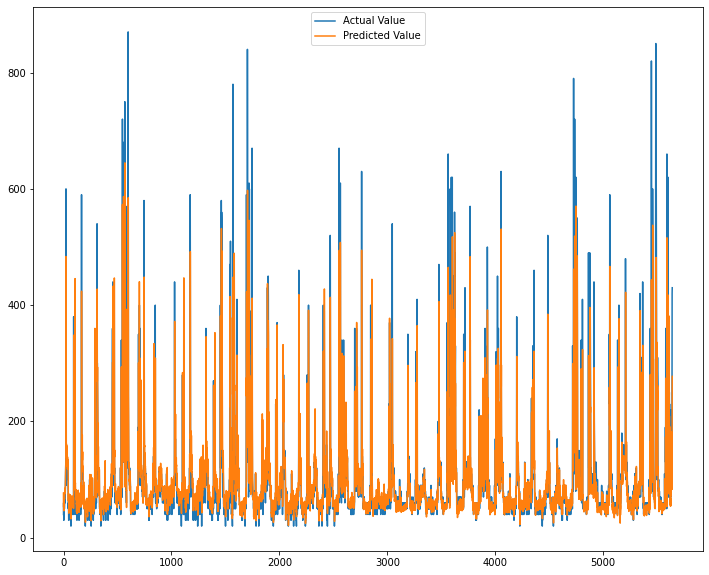

In [83]:
plt.figure(figsize=(12,10))
plt.plot(Final_df.Actual_Value, label = "Actual Value")
plt.plot(Final_df.Predicted_value, label = "Predicted Value")
plt.legend()
plt.show()